In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#### Build dataset

In [2]:
def build_toy_dataset(N, noise_std=0.1):
    X = np.random.uniform(-10, 10, size=[N, 2])
    y = 2*X[:, 0] - X[:, 1] + np.random.normal(5, 0.3, size=N)
    y[y < 0.0] = 0
    y[y > 0.0] = 1
    return X, y.reshape(N, 1)

N = 300  # number of data points
# DATA
np.random.seed(42)
X_train, y_train = build_toy_dataset(N)

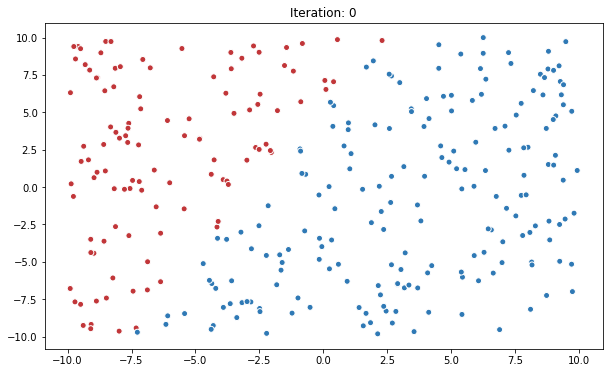

In [3]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")

ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train.reshape(N), cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")

ax.legend()
plt.show()

# grid for countour map
xx1, xx2 = np.mgrid[-10:10:.1, -10:10:.1]
grid = np.c_[xx1.ravel(), xx2.ravel()]
#grid = tf.constant(grid, dtype=tf.float32)

#### Logistic models

In [4]:
X = tf.placeholder(tf.float32, shape=[None, 2])
y = tf.placeholder(tf.float32, shape=[None, 1])

with tf.variable_scope("Logistic_regression"):
    W = tf.get_variable('weight', shape=[2, 1], initializer=tf.truncated_normal_initializer())
    b = tf.get_variable('bias', shape=[1], initializer=tf.zeros_initializer())
    
    logits = tf.add(tf.matmul(X, W), b)
    probs = tf.sigmoid(logits)
    # Use the self defined loss, for brevity, y * -log(sigmoid(x)) + (1 - y) * -log(1 - sigmoid(x)) has numerical instability
    # due to the overflow risk from exp() operation.
    sum_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(sum_loss)
    
"""
The default opt would update every trainable variable. To control specific updates (e.g., train a GAN), set params 'var_list' in 
opt.minimize(loss, var_list=[W]) to update only 'W' for example.
"""

opt = tf.train.AdamOptimizer(0.01)

train_op = opt.minimize(loss)

# or manully

# The below returns [grads, vars]
grads_and_vars = opt.compute_gradients(loss)
# Add grads to vars
apply_gradient_op = opt.apply_gradients(grads_and_vars)

#### Training

In [5]:
with tf.Session() as sess:
    """
    Run initializer to initialize variables, this operation calls to run the above tf.zeros_initializer() 
    and tf.truncated_normal_initializer()
    """
    tf.global_variables_initializer().run()  
    for i in range(1000):
        loss_val, _ = sess.run([loss, apply_gradient_op], feed_dict={X:X_train, y:y_train})
    final_model = sess.run(probs, feed_dict={X: grid})     
    print("After 1000 iterations loss %.2f" % loss_val)

After 1000 iterations loss 0.07


#### Final model visualization

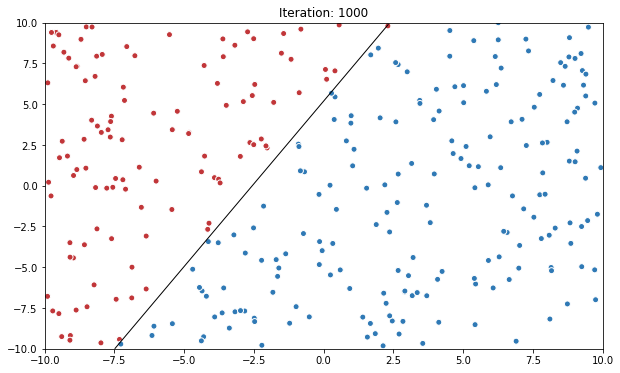

In [6]:
# FIRST VISUALIZATION (prior)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 1000")

ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train.reshape(N), cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")

ax.contour(xx1, xx2, final_model.reshape(200,200), levels=[.5], cmap="Greys", vmin=0, vmax=.1, linewidths=1)

ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.legend()
plt.show()